# imports

In [66]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import os

os.chdir("/data")

In [68]:
!pip install -q -U keras-tuner --quiet

In [69]:
import re
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from transformers import (
    AutoTokenizer,
    TFAutoModel,
    TFAutoModelForSequenceClassification,
)
from transformers import logging


logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "plotly_white"
pd.options.plotting.backend = "matplotlib"
tf.random.set_seed(66)

import keras_tuner as kt

In [70]:
def zscore_roll(data, window=90, min_win=90, ewm=True, fill_early=True):
    if ewm:
        roll = data.ewm(span=window, min_periods=min_win)
    else:
        roll = data.rolling(window, min_periods=min_win)

    m = roll.mean()
    s = roll.std()
    if fill_early:
        m[:min_win] = data[:min_win].mean()
        s[:min_win] = data[:min_win].std()
    return (data - m) / s

# Load Data

## train data

In [71]:
news_train = pd.read_csv("reuters_news_2006_2013.csv").dropna()
news_train.shape

(105343, 3)

In [72]:
news_train["date"] = pd.to_datetime(news_train["date"], format="%Y%m%d")

In [73]:
news_train.head()

,date,title,summary
0,2006-11-13,"Hitachi, GE boost alliance in nuclear power bu...",TOKYO (Reuters) - Hitachi Ltd. ( 6501.T ) sai...
1,2006-11-13,"Volvo to cut 1,000 staff at Virginia plant",STOCKHOLM (Reuters) - Truck maker Volvo said ...
2,2006-11-13,European banks hiding full pension obligations,"ZURICH, Nov 13 (Reuter) - West European banks ..."
3,2006-11-13,"Hitachi, GE to form joint nuclear power ventures",TOKYO (Reuters) - Japan's Hitachi Ltd. and U....
4,2006-11-13,Eddie Bauer agrees to be bought for $286 million,(Reuters) - Eddie Bauer Holdings Inc. EBHI.O s...


In [74]:
p_train = pd.read_csv("spx_2006_2013.csv", index_col=0, parse_dates=True)["Adj Close"]

<Axes: xlabel='Date'>

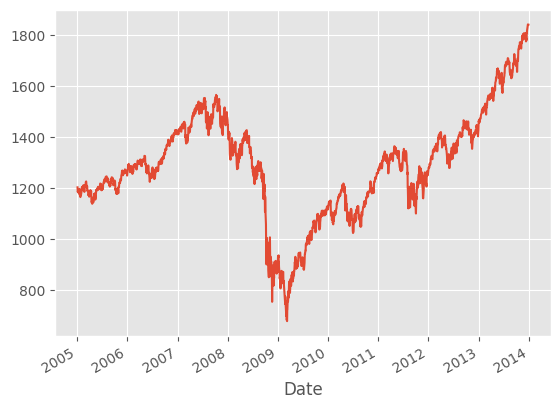

In [75]:
p_train.plot()

In [76]:
hist_returns_train = zscore_roll(np.log(p_train).diff()).rename(
    "hist_ret"
)  # calculate historical returns and standardize it
labels_train = hist_returns_train.shift(-1).rename(
    "label"
)  # we need to predict next day's change

In [77]:
combined_train = news_train.merge(
    pd.concat([labels_train, hist_returns_train], axis=1).reset_index(),
    left_on="date",
    right_on="Date",
)  # join the news with returns data

In [78]:
combined_train.drop("Date", axis=1, inplace=True)
combined_train = combined_train.sort_values("date")

In [79]:
combined_train.tail()

,date,title,summary,label,hist_ret
52839,2013-11-20,"Bernanke: looking forward to writing, speaking...",WASHINGTON (Reuters) - Federal Reserve Chairm...,1.031708,-0.680484
52838,2013-11-20,Mazda CEO says to begin production at key Mexi...,TOKYO (Reuters) - Mazda Motor Corp ( 7261.T )...,1.031708,-0.680484
52837,2013-11-20,J&J unit to pay $2.5 billion in U.S. hip impla...,NEW YORK (Reuters) - A unit of Johnson & John...,1.031708,-0.680484
52836,2013-11-20,Nissan to lift U.S. output of Leaf electric ca...,LOS ANGELES (Reuters) - Nissan Motor Co Ltd (...,1.031708,-0.680484
52842,2013-11-20,"Dow, S&P retreat for second day; Best Buy weighs",NEW YORK (Reuters) - U.S. stocks fell on Tues...,1.031708,-0.680484


## test data

In [80]:
news_test = pd.read_csv("reuters_news_with_prob.csv").dropna()
news_test["date"] = pd.to_datetime(news_test["Time"])
news_test.shape

(32770, 9)

In [81]:
news_test.sort_values("Time")

,Headlines,Time,Description,prob_netrual,prob_positive,prob_negative,sent,prob_diff,date
32769,UK will always consider ways to improve data l...,2018-03-20,Britain will consider any suggestions to give ...,0.005661,5.274095e-05,0.994286,0,-0.994233,2018-03-20
32738,Senate Democrat wants Facebook CEO Zuckerberg ...,2018-03-20,"U.S. Senator Dianne Feinstein, the top Democra...",0.999764,8.882130e-06,0.000227,1,-0.000218,2018-03-20
32737,"Factbox: How United States, others regulate au...",2018-03-20,An Uber self-driving sport utility vehicle str...,0.737891,1.940052e-02,0.242708,1,-0.223308,2018-03-20
32736,Cambridge Analytica played key Trump campaign ...,2018-03-20,The suspended chief executive of UK-based poli...,0.996708,2.320829e-05,0.003269,1,-0.003246,2018-03-20
32735,Start of AT&T-Time Warner trial delayed until ...,2018-03-20,Opening statements in the trial to decide if A...,0.049392,2.573617e-06,0.950605,0,-0.950603,2018-03-20
...,...,...,...,...,...,...,...,...,...
39,Exclusive: Pact to aid poor cocoa farmers in p...,2020-07-17,The steepest dive in cocoa demand in a decade ...,0.195013,2.209833e-03,0.802777,0,-0.800567,2020-07-17
3,Twitter says attackers downloaded data from up...,2020-07-18,Twitter Inc said on Saturday that hackers were...,0.999919,3.417601e-05,0.000046,1,-0.000012,2020-07-18
2,Trail of missing Wirecard executive leads to B...,2020-07-18,Former Wirecard chief operating officer Jan M...,0.999968,6.219325e-09,0.000032,1,-0.000032,2020-07-18
1,Disney cuts ad spending on Facebook amid growi...,2020-07-18,Walt Disney has become the latest company to ...,0.052558,3.036877e-05,0.947411,0,-0.947381,2020-07-18


<Axes: xlabel='Date'>

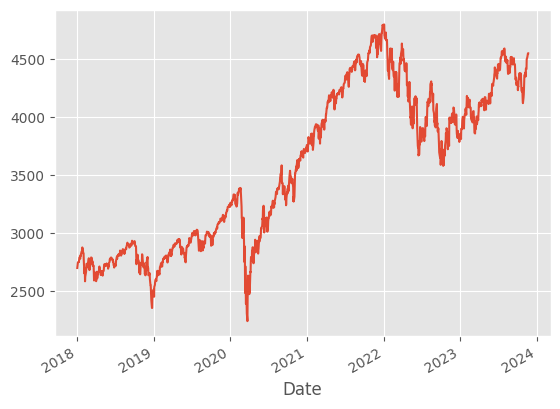

In [82]:
p_test = (
    pd.read_csv("price_of_major_assets.csv", index_col=0, parse_dates=True)["stock"]
    .ffill()
    .dropna()
)
p_test.plot()

In [83]:
hist_returns_test = zscore_roll(np.log(p_test.ffill()).diff()).rename("hist_ret")
labels_test = hist_returns_test.shift(-1).rename("label")
combined_test = news_test.merge(
    pd.concat([labels_test, hist_returns_test], axis=1).reset_index(),
    left_on="date",
    right_on="Date",
)  # join the news with returns datacombined.drop('Date',axis=1,inplace=True)
combined_test = combined_test.sort_values("date")

combined_test.tail()

,Headlines,Time,Description,prob_netrual,prob_positive,prob_negative,sent,prob_diff,date,Date,label,hist_ret
28,Exclusive: Thyssenkrupp to explore further opt...,2020-07-17,Thyssenkrupp is seeking new ways to strengthe...,0.000008,0.999992,5.806786e-07,2,0.999991,2020-07-17,2020-07-17,0.320401,0.065942
27,"UBS, Morgan Stanley expected to lead Vodafone ...",2020-07-17,UBS and Morgan Stanley are expected to organ...,0.974843,0.025146,1.102120e-05,1,0.025135,2020-07-17,2020-07-17,0.320401,0.065942
26,As big U.S. banks let customers delay payments...,2020-07-17,Major U.S. bank executives this week said they...,0.731482,0.002488,2.660300e-01,1,-0.263542,2020-07-17,2020-07-17,0.320401,0.065942
24,End of the jumbo: British Airways retires 747 ...,2020-07-17,"British Airways, the world's largest operator ...",0.987032,0.000336,1.263200e-02,1,-0.012296,2020-07-17,2020-07-17,0.320401,0.065942
0,U.S. Republicans seek liability protections as...,2020-07-17,A battle in the U.S. Congress over a new coron...,0.690913,0.003156,3.059306e-01,1,-0.302774,2020-07-17,2020-07-17,0.320401,0.065942


In [84]:
labels_test[labels_test.isna()]

Date
2023-11-21   NaN
Name: label, dtype: float64

In [85]:
labels_train = combined_train.groupby("date")["label"].last()
hist_train = combined_train.groupby("date")["hist_ret"].last().to_numpy()
labels_test = combined_test.groupby("date")["label"].last()
hist_test = combined_test.groupby("date")["hist_ret"].last().to_numpy()

In [86]:
labels_train.shape, labels_test.shape

((1784,), (609,))

In [87]:
labels_train.shape[0] + labels_test.shape[0]

2393

# Lexicon

In [ ]:
import nltk

nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

sent_nltk = [sia.polarity_scores(i) for i in combined_test["Description"]]

In [ ]:
nltk_result = pd.DataFrame(sent_nltk)

In [ ]:
nltk_result.corr()

,neg,neu,pos,compound
neg,1.000000,-0.660624,-0.136257,-0.740265
neu,-0.660624,1.000000,-0.653693,0.029335
pos,-0.136257,-0.653693,1.000000,0.707512
compound,-0.740265,0.029335,0.707512,1.000000


In [ ]:
combined_test[
    ["nltk_neg", "nltk_neu", "nltk_pos", "nltk_compound"]
] = nltk_result.to_numpy()

In [ ]:
combined_test["nltk_prob_diff"] = combined_test["nltk_pos"] - combined_test["nltk_neg"]

In [ ]:
combined_test[["prob_diff", "nltk_prob_diff"]].corr()

,prob_diff,nltk_prob_diff
prob_diff,1.00000,0.42412
nltk_prob_diff,0.42412,1.00000


# FinBERT Senti


# Load Pre-trained Model

In [ ]:
checkpoint = "yiyanghkust/finbert-tone"
# This is a bert model fine-tuned with financial news and articles. It can output sentiments(POSTIVE, NERUTRAL and NEGATIVE) directly
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)
model_class = TFAutoModelForSequenceClassification.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
def count_words(text):
    words = text.split()
    return len(words)

news_train["title"].apply(count_words).describe()
# combined_test['Description'].apply(count_words).quantile(0.99)
# the word count shows MAX_SEQUENCE_LENGTH=100 may be enough

count    105343.000000
mean          7.957548
std           1.553762
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          18.000000
Name: title, dtype: float64

In [ ]:
MAX_SEQUENCE_LENGTH = 100

In [ ]:
text = combined_test["Description"].to_list()
text_tokenized = tokenizer(
    text,
    max_length=MAX_SEQUENCE_LENGTH,
    truncation=True,
    padding="max_length",
    return_tensors="tf",
)

In [ ]:
# get the output from the pretrained model
output = model_class.predict(
    [text_tokenized["input_ids"], text_tokenized["attention_mask"]]
)

2891/2891 [==============================] - 637s 217ms/step


In [ ]:
probs = tf.nn.softmax(output["logits"], axis=-1)

In [ ]:
combined_test[["prob_netrual", "prob_positive", "prob_negative"]] = probs
combined_test["sentiment"] = np.argmax(probs, axis=1)
combined_test["sentiment"].replace(
    {2: 0, 0: 1, 1: 2}, inplace=True
)  # adjust the levels
combined_test["prob_diff"] = (
    combined_test["prob_positive"] - combined_test["prob_negative"]
)

In [ ]:
combined_test.to_csv("reuters_news_1820_with_prob.csv", index=False)

In [ ]:
sentiment_daily = combined_test.groupby("date")[
    ["prob_diff", "nltk_prob_diff", "label"]
].mean()

In [ ]:
sentiment_daily.head()

,prob_diff,nltk_prob_diff,label,signal_finbert,signal_nltk
date,,,,,
2018-03-20,-0.146166,-0.006125,-0.001846,0,-1
2018-03-21,-0.096920,0.029419,-0.025485,0,0
2018-03-22,-0.305464,0.013658,-0.021190,-1,0
2018-03-23,-0.095209,0.029927,0.026795,0,0
2018-03-26,-0.090110,0.013000,-0.017427,0,0


<Axes: xlabel='date'>

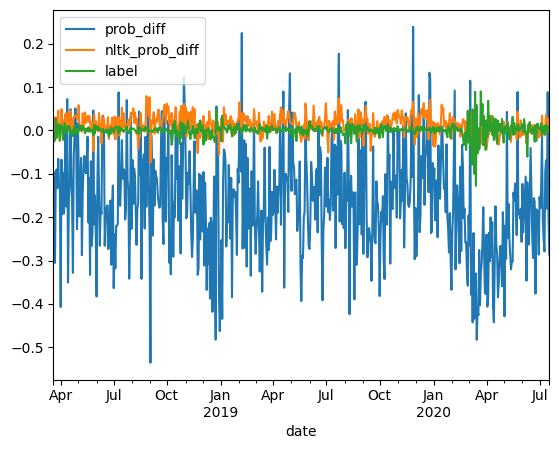

In [ ]:
sentiment_daily.plot()

In [ ]:
sentiment_daily["signal_finbert"] = (
    pd.qcut(sentiment_daily["prob_diff"], [0, 0.2, 0.8, 1], labels=False) - 1
)
sentiment_daily["signal_nltk"] = (
    pd.qcut(sentiment_daily["nltk_prob_diff"], [0, 0.2, 0.8, 1], labels=False) - 1
)

In [ ]:
sentiment_daily.corr()

,prob_diff,nltk_prob_diff,label,signal_finbert,signal_nltk
prob_diff,1.000000,0.514312,-0.027413,0.889964,0.483868
nltk_prob_diff,0.514312,1.000000,0.005603,0.476676,0.883863
label,-0.027413,0.005603,1.000000,0.003182,0.016854
signal_finbert,0.889964,0.476676,0.003182,1.000000,0.471311
signal_nltk,0.483868,0.883863,0.016854,0.471311,1.000000


<Axes: xlabel='date'>

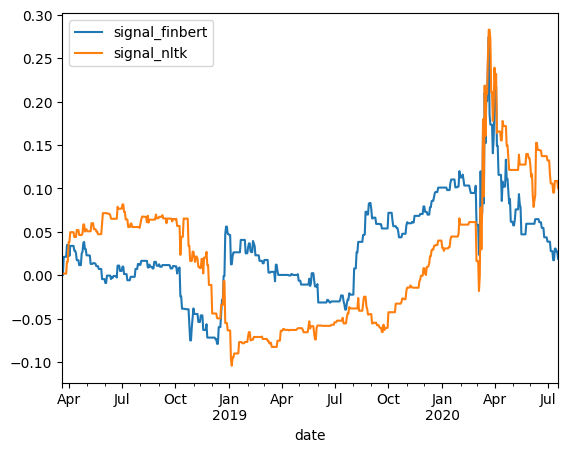

In [ ]:
(
    sentiment_daily[["signal_finbert", "signal_nltk"]].mul(
        sentiment_daily["label"], axis=0
    )
).cumsum().plot()

In [ ]:
sentiment_daily[
    ["prob_diff", "nltk_prob_diff", "signal_finbert", "signal_nltk", "label"]
].to_csv("result_finbert_nltk.csv")

# Fine-tuning with pooler

## get the pooler output for each news

In [ ]:
def extract_pooler(model):
    input_ids = tf.keras.layers.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name="input_ids_layer"
    )
    attention_mask = tf.keras.layers.Input(
        shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name="attention_mask_layer"
    )
    input = {"input_ids": input_ids, "attention_mask": attention_mask}
    pooler_layer = model(input)["pooler_output"]
    extract_model = tf.keras.Model(inputs=[input], outputs=[pooler_layer])
    return extract_model

In [ ]:
extract_model = extract_pooler(model)

In [ ]:
output = extract_model.predict(
    [text_tokenized["input_ids"], text_tokenized["attention_mask"]]
)

2891/2891 [==============================] - 633s 218ms/step


In [ ]:
np.save("pooler_output", output)

## padding the news to 50 per day

In [ ]:
combined_train.groupby("date")["summary"].count().describe()

count    1784.000000
mean       51.843610
std        15.134606
min         2.000000
25%        41.000000
50%        50.000000
75%        60.000000
max       114.000000
Name: summary, dtype: float64

In [ ]:
# we basically follow the process before, only this time the input has dim of 768 instead of 3, so we need to shorten the num of news per day
MAX_X_LEN = 50

In [ ]:
x_all = []
for i in y.index:
    x = output[labels_train["date"] == i]
    if x.shape[0] < MAX_X_LEN:
        x = x.copy()
        x.resize((MAX_X_LEN, 768))
        x_all.append(x)
    else:
        x_all.append(x[:MAX_X_LEN, :])

In [ ]:
x_all = np.array(x_all)

In [ ]:
np.save("padded_pooler_x_0613.npy", x_all)

In [ ]:
x_all_train = np.load("padded_pooler_x_0613.npy")
x_all_test = np.load("padded_pooler_x.npy")

In [ ]:
x_all_train.shape, x_all_test.shape

((1784, 50, 768), (609, 50, 768))

In [ ]:
labels_combined = combined_test.groupby("date")["label"].last()
val_size = int(labels_combined.shape[0] / 2)
val_size

304

In [ ]:
x_train = x_all_train
x_val = x_all_test[:val_size]
x_test = x_all_test[val_size:]

In [ ]:
y_train = combined_train.groupby("date")["label"].last()
y_val = labels_combined[:val_size]
y_test = labels_combined[val_size:]

In [ ]:
x_test.shape, y_test.shape

((305, 50, 768), (305,))

In [ ]:
def predict_and_evaluate(model, x_test, label):
    predicts = model.predict(x_test)
    result = pd.DataFrame(label)
    result["predict"] = predicts
    result["pos_quantile"] = (
        pd.qcut(result["predict"], [0, 0.2, 0.8, 1], labels=False) - 1
    )
    # result["pos_sign"] = np.sign(result["predict"])
    result['pos']=np.tanh(zscore_roll(result["predict"],200,200))
    print(result.corr())
    result[["predict", "label"]].plot(secondary_y="label")
    plt.show()
    (result["pos"] * result["label"]).cumsum().plot()
    plt.show()
    return result

## model with single day info

### FB Avg

In [ ]:
def create_model_avg_pooler(hp):
    input = tf.keras.layers.Input(shape=(MAX_X_LEN, 768))
    avg_layer = tf.reduce_mean(input, axis=1)
    flatten = tf.keras.layers.Flatten()(avg_layer)
    hp_hidden_units=hp.Choice('hidden_units',values=[8,16,32])
    hidden = tf.keras.layers.Dense(
        hp_hidden_units,
    )(flatten)
    hp_dropout=hp.Choice('droupout',values=[0.3,0.5])
    droput = tf.keras.layers.Dropout(hp_dropout)(hidden)
    reg = tf.keras.layers.Dense(1)(droput)
    model = tf.keras.models.Model(inputs=[input], outputs=[reg])
    hp_learning_rate=hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="mse"
    )
    return model

In [ ]:
tuner = kt.Hyperband(create_model_avg_pooler,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='model_hp',
                     project_name='model_avg_pooler')

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5
)

In [ ]:
tuner.search(
    x_train,
    y_train,
    validation_data=[x_val, y_val],
    batch_size=128,
    epochs=10,
    callbacks=[early_stopping],
)

Trial 19 Complete [00h 00m 03s]
val_loss: 0.8590086698532104

Best val_loss So Far: 0.8529786467552185
Total elapsed time: 00h 01m 32s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_avg_pooler=tuner.hypermodel.build(best_hps)
history = model_avg_pooler.fit(
    x_train,
    y_train,
    validation_data=[x_val, y_val],
    batch_size=128,
    epochs=20,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/20
14/14 [==============================] - 2s 46ms/step - loss: 1.1510 - val_loss: 0.8835
Epoch 2/20
14/14 [==============================] - 0s 24ms/step - loss: 1.0711 - val_loss: 0.8600
Epoch 3/20
14/14 [==============================] - 0s 25ms/step - loss: 1.0400 - val_loss: 0.8884
Epoch 4/20
14/14 [==============================] - 0s 27ms/step - loss: 1.0147 - val_loss: 0.8773
Epoch 5/20
14/14 [==============================] - 0s 23ms/step - loss: 0.9860 - val_loss: 0.8624
Epoch 6/20
14/14 [==============================] - 0s 23ms/step - loss: 0.9554 - val_loss: 0.8600
Epoch 7/20
14/14 [==============================] - 0s 22ms/step - loss: 0.9516 - val_loss: 0.8635
Epoch 8/20
14/14 [==============================] - 0s 22ms/step - loss: 0.9515 - val_loss: 0.8726
Epoch 9/20
14/14 [==============================] - 0s 23ms/step - loss: 0.9500 - val_loss: 0.8600
Epoch 10/20
14/14 [==============================] - 0s 20ms/step - loss: 0.9395 - val_loss: 0.8681
Epoch 11/

10/10 [==============================] - 0s 3ms/step
                 label   predict  pos_quantile       pos
label         1.000000  0.026915      0.006627  0.037696
predict       0.026915  1.000000      0.888997  0.947458
pos_quantile  0.006627  0.888997      1.000000  0.840875
pos           0.037696  0.947458      0.840875  1.000000


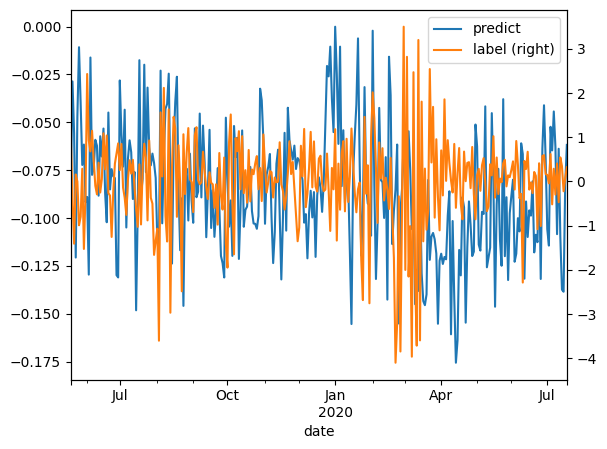

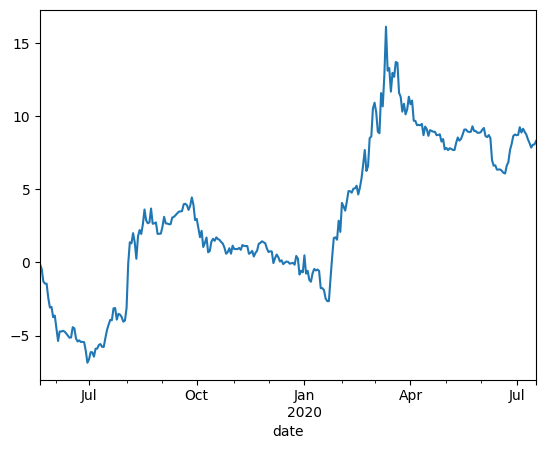

In [ ]:
result_avg = predict_and_evaluate(model_avg_pooler,x_test,y_test)

In [ ]:
result_avg.to_csv("result_avg_single_day.csv")

### FB Attention

In [ ]:
def create_model_avg_attention(hp):
    input = tf.keras.layers.Input(shape=(MAX_X_LEN, 768))
    hp_attention_heads=hp.Choice('attention_heads',values=[1,2,4])
    attention = tf.keras.layers.MultiHeadAttention(num_heads=hp_attention_heads, key_dim=MAX_X_LEN//hp_attention_heads)(
        input, input
    )
    attention_flatten = tf.reduce_mean(attention, axis=1)
    hp_hidden_units=hp.Choice('hidden_units',values=[8,16,32])
    hidden = tf.keras.layers.Dense(
        hp_hidden_units,
    )(attention_flatten)
    hp_dropout=hp.Choice('droupout',values=[0.3,0.5])
    droput = tf.keras.layers.Dropout(hp_dropout)(hidden)
    reg = tf.keras.layers.Dense(1)(droput)
    model = tf.keras.models.Model(inputs=[input], outputs=[reg])
    hp_learning_rate=hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="mse"
    )
    return model

In [ ]:
tuner = kt.Hyperband(create_model_avg_attention,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='model_hp',
                     project_name='model_avg_attention')

In [ ]:
tuner.search(
    x_train,
    y_train,
    validation_data=[x_val, y_val],
    batch_size=128,
    epochs=10,
    callbacks=[early_stopping],
)

Trial 30 Complete [00h 00m 07s]
val_loss: 0.8565629720687866

Best val_loss So Far: 0.8534449338912964
Total elapsed time: 00h 02m 53s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_avg_attention=tuner.hypermodel.build(best_hps)
model_avg_attention.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 768)]            0         []                            
                                                                                                  
 multi_head_attention_1 (Mu  (None, 50, 768)              148368    ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 tf.math.reduce_mean_1 (TFO  (None, 768)                  0         ['multi_head_attention_1[0][0]
 pLambda)                                                           ']                            
                                                                                            

In [ ]:
history = model_avg_attention.fit(
    x_train,
    y_train,
    validation_data=[x_val, y_val],
    batch_size=128,
    epochs=20,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/20
14/14 [==============================] - 2s 39ms/step - loss: 583.5421 - val_loss: 72.6373
Epoch 2/20
14/14 [==============================] - 0s 22ms/step - loss: 82.3836 - val_loss: 24.4546
Epoch 3/20
14/14 [==============================] - 0s 24ms/step - loss: 30.3405 - val_loss: 4.8513
Epoch 4/20
14/14 [==============================] - 0s 22ms/step - loss: 7.5265 - val_loss: 1.0549
Epoch 5/20
14/14 [==============================] - 0s 23ms/step - loss: 2.4063 - val_loss: 1.5295
Epoch 6/20
14/14 [==============================] - 0s 22ms/step - loss: 1.2916 - val_loss: 0.8847
Epoch 7/20
14/14 [==============================] - 0s 22ms/step - loss: 1.0126 - val_loss: 0.8556
Epoch 8/20
14/14 [==============================] - 0s 22ms/step - loss: 0.9760 - val_loss: 0.8828
Epoch 9/20
14/14 [==============================] - 0s 21ms/step - loss: 0.9867 - val_loss: 0.8772
Epoch 10/20
14/14 [==============================] - 0s 22ms/step - loss: 0.9701 - val_loss: 0.8614
Epo

10/10 [==============================] - 0s 4ms/step
                 label   predict  pos_quantile       pos
label         1.000000  0.077341      0.041393  0.073714
predict       0.077341  1.000000      0.587912  0.994642
pos_quantile  0.041393  0.587912      1.000000  0.583055
pos           0.073714  0.994642      0.583055  1.000000


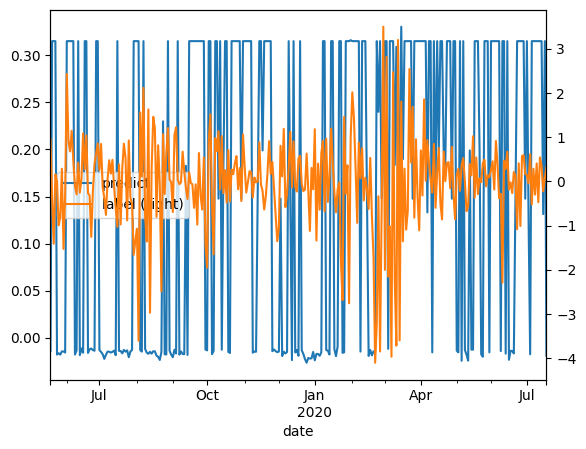

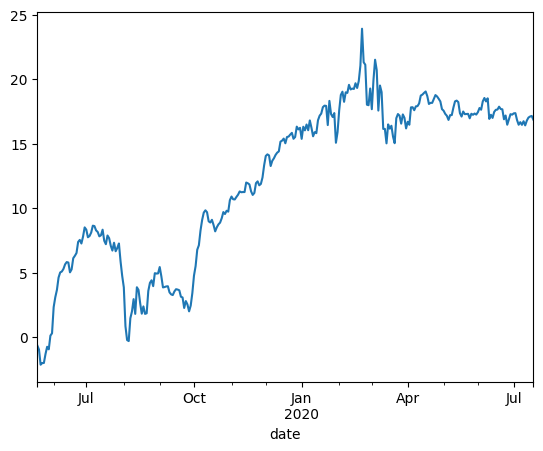

In [ ]:
result_avg = predict_and_evaluate(model_avg_attention,x_test,y_test)

In [ ]:
result_avg.to_csv("result_attention_single_data.csv")

## model with rolling window

In [ ]:
WINDOW = 60

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

news_roll_train = sliding_window_view(x_all_train, WINDOW, axis=0)
hist_roll_train = sliding_window_view(hist_train, WINDOW, axis=0)
labels_train_np = labels_train[WINDOW - 1 :].to_numpy()
news_roll_test = sliding_window_view(x_all_test, WINDOW, axis=0)
hist_roll_test = sliding_window_view(hist_test, WINDOW, axis=0)
labels_test_np = labels_test[WINDOW - 1 :].to_numpy()

In [ ]:
labels_train_np.shape

(1725,)

In [ ]:
assert news_roll_train.shape[0] == hist_roll_train.shape[0] == labels_train_np.shape[0]
assert news_roll_test.shape[0] == hist_roll_test.shape[0] == labels_test_np.shape[0]

In [ ]:
import math
class RollingGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_news, x_hist, y, batch_size=32):
        self.x_news, self.x_hist, self.y = x_news, x_hist, y
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(self.x_news.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        low = idx * self.batch_size
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size, self.x_news.shape[0])
        batch_x_news = self.x_news[low:high]
        batch_x_hist = self.x_hist[low:high]
        batch_y = self.y[low:high]

        return [batch_x_news, batch_x_hist], batch_y

In [ ]:
test_size = 305  # to be comparable with previouse tests

train_ds = RollingGenerator(news_roll_train, hist_roll_train, labels_train_np)
val_ds = RollingGenerator(
    news_roll_test[:-test_size],
    hist_roll_test[:-test_size],
    labels_test_np[:-test_size],
)
test_ds = RollingGenerator(
    news_roll_test[-test_size:],
    hist_roll_test[-test_size:],
    labels_test_np[-test_size:],
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, mode="auto", restore_best_weights=True
)

### FB Transformer

In [ ]:
class PositionalEncodingLayer(tf.keras.layers.Layer):
    """add a positional index to the input"""
    def __init__(self):
        super().__init__()

    def call(self, input):
        positions = tf.tile(tf.reshape(tf.range(60, dtype=tf.int32)/60, (1, -1)), [tf.shape(input)[0], 1])
        input_with_position=tf.stack([input, tf.cast(positions, tf.float32)], axis=-1)
        return input_with_position

class FeedForward(tf.keras.layers.Layer):
    """wrap the feed forward steps"""
    def __init__(self):
        super().__init__()

    def call(self,input,hidden_units,dropout):
        hidden = tf.keras.layers.Dense(hidden_units)(input)
        hidden = tf.keras.layers.Dense(hidden_units)(hidden)
        flattened=tf.keras.layers.Flatten()(hidden)
        droput_layer = tf.keras.layers.Dropout(dropout)(flattened)
        return droput_layer

positional_encoding_news = PositionalEncodingLayer()
positional_encoding_hist = PositionalEncodingLayer()
ff=FeedForward()

def create_model_mini_transformer(hp):

    # define hyperparameters for auto-hyper
    hp_attention_heads=hp.Choice('attention_heads',values=[1,2,4])
    hp_hidden_units=hp.Choice('hidden_units',values=[8,16,32])
    hp_dropout=hp.Choice('droupout',values=[0.3,0.5])
    hp_learning_rate=hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

    # two inputs source
    input_news = tf.keras.layers.Input(shape=(MAX_X_LEN, 768, WINDOW))
    input_hist = tf.keras.layers.Input(shape=(WINDOW,))

    # news input with attention
    attention_news = tf.keras.layers.MultiHeadAttention(
        num_heads=hp_attention_heads, key_dim=2, attention_axes=1
    )(input_news, input_news)
    attention_news_mean = tf.reduce_mean(
        attention_news, axis=1
    )  # combine data within the same date
    attention_news_token = tf.keras.layers.MultiHeadAttention(
        num_heads=hp_attention_heads, key_dim=2, attention_axes=1
    )(attention_news_mean, attention_news_mean)
    attention_news_token_mean = tf.reduce_mean(attention_news_token, axis=1)
    flatten_news = tf.keras.layers.Normalization()(attention_news_token_mean)
    news_with_position=positional_encoding_news(flatten_news)

    # hist returns with attention
    attention_hist = tf.keras.layers.MultiHeadAttention(
        num_heads=hp_attention_heads, key_dim=2, attention_axes=1
    )(input_hist, input_hist)
    flatten_hist = tf.keras.layers.Normalization()(attention_hist)
    hist_with_position=positional_encoding_hist(flatten_hist)

    # cross attention between two inputs
    cross_attention_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=hp_attention_heads, key_dim=2, attention_axes=1
    )(news_with_position, hist_with_position)
    ff_output=ff(cross_attention_layer,hp_hidden_units,hp_dropout)
    reg = tf.keras.layers.Dense(1)(ff_output)

    model = tf.keras.models.Model(inputs=(input_news, input_hist), outputs=[reg])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mse"
    )
    return model

In [ ]:
tuner = kt.Hyperband(create_model_mini_transformer,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='model_hp',
                     project_name='model_mini_transformer')

Reloading Tuner from model_hp/model_mini_transformer/tuner0.json


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3
)

In [ ]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    shuffle=True,
    callbacks=[early_stopping],
)

Trial 30 Complete [00h 05m 16s]
val_loss: 0.881438136100769

Best val_loss So Far: 0.8592086434364319
Total elapsed time: 01h 00m 19s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'attention_heads': 2,
 'hidden_units': 8,
 'droupout': 0.3,
 'learning_rate': 0.001,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0012'}

In [ ]:
model_mini_transformer=tuner.hypermodel.build(best_hps)
model_mini_transformer.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 50, 768, 60)]        0         []                            
                                                                                                  
 multi_head_attention_48 (M  (None, 50, 768, 60)          1032      ['input_31[0][0]',            
 ultiHeadAttention)                                                  'input_31[0][0]']            
                                                                                                  
 tf.math.reduce_mean_30 (TF  (None, 768, 60)              0         ['multi_head_attention_48[0][0
 OpLambda)                                                          ]']                           
                                                                                            

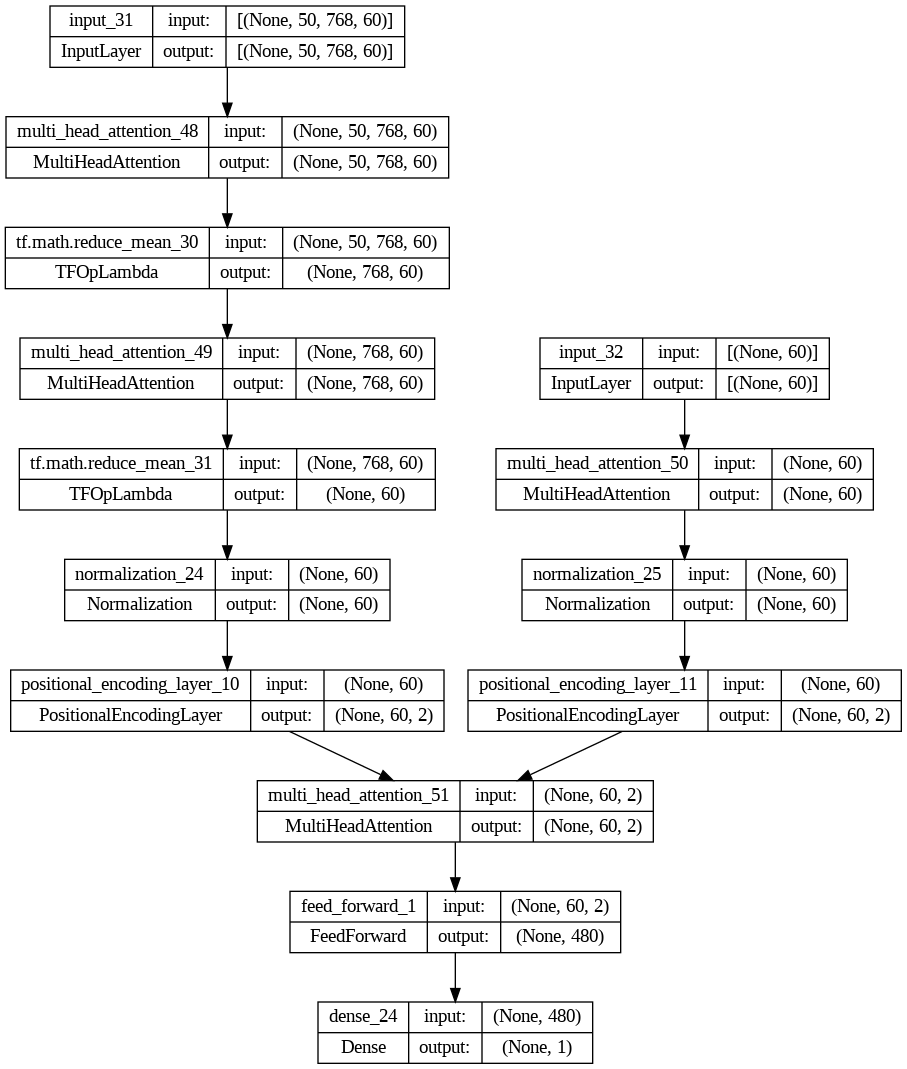

In [ ]:
tf.keras.utils.plot_model(model_mini_transformer, show_shapes=True)

In [ ]:
history = model_mini_transformer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3,restore_best_weights=True
)],
    shuffle=True
)

Epoch 1/10


54/54 [==============================] - 41s 686ms/step - loss: 1.0287 - val_loss: 0.8842
Epoch 2/10
54/54 [==============================] - 33s 610ms/step - loss: 0.9465 - val_loss: 0.8811
Epoch 3/10
54/54 [==============================] - 31s 580ms/step - loss: 0.9462 - val_loss: 0.8819
Epoch 4/10
54/54 [==============================] - 32s 582ms/step - loss: 0.9455 - val_loss: 0.8822
Epoch 5/10
54/54 [==============================] - 35s 648ms/step - loss: 0.9454 - val_loss: 0.8816


10/10 [==============================] - 5s 444ms/step
                 label   predict  pos_quantile       pos
label         1.000000  0.157672      0.118898  0.174371
predict       0.157672  1.000000      0.854083  0.957935
pos_quantile  0.118898  0.854083      1.000000  0.794434
pos           0.174371  0.957935      0.794434  1.000000


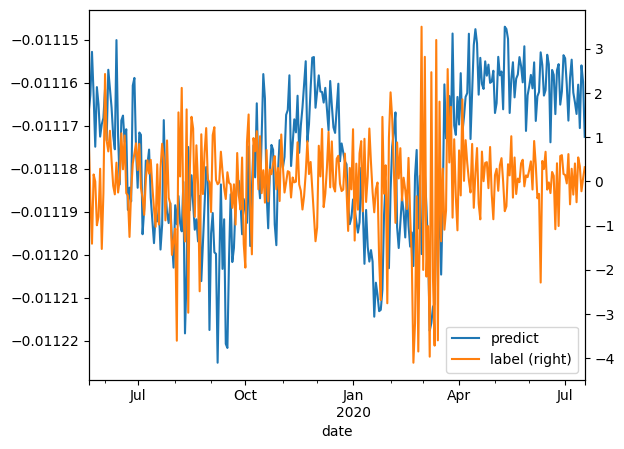

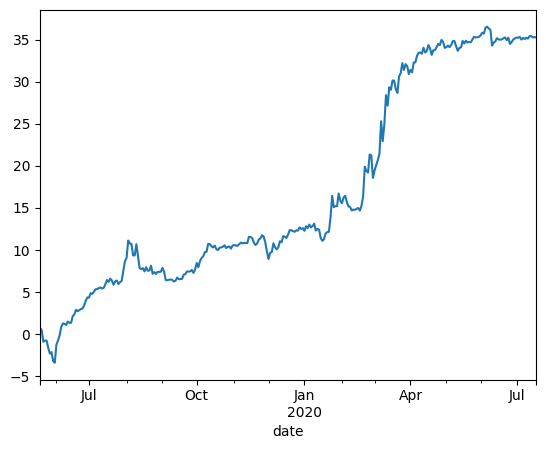

In [ ]:
result_transformer = predict_and_evaluate(model_mini_transformer,test_ds, labels_test[-test_size:])

In [ ]:
model_mini_transformer.save('model/mini_transformer', save_format='tf')

In [ ]:
result_transformer.to_csv("result_transformer_autohp.csv")

### FB LSTM

In [ ]:
def create_model_attention_lstm(hp):
    # define hyperparameters for auto-hyper
    hp_lstm_units=hp.Choice('lstm_units',values=[8,32])
    hp_hidden_units=hp.Choice('hidden_units',values=[8,32])
    hp_dropout=hp.Choice('droupout',values=[0.3,0.5])
    hp_learning_rate=hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

    # two inputs source
    input_news = tf.keras.layers.Input(shape=(MAX_X_LEN, 768, WINDOW))
    input_hist = tf.keras.layers.Input(shape=(WINDOW,))

    # news input with attention
    attention_news = tf.keras.layers.MultiHeadAttention(
        num_heads=2, key_dim=2, attention_axes=1
    )(input_news, input_news)
    attention_news_mean = tf.reduce_mean(
        attention_news, axis=1
    )  # combine data within the same date
    attention_news_token = tf.keras.layers.MultiHeadAttention(
        num_heads=2, key_dim=2, attention_axes=1
    )(attention_news_mean, attention_news_mean)
    attention_news_token_mean = tf.reduce_mean(attention_news_token, axis=1)


    # hist returns with attention
    attention_hist = tf.keras.layers.MultiHeadAttention(
        num_heads=2, key_dim=2, attention_axes=1
    )(input_hist, input_hist)

    # combine two inputs together
    cross_attention_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=1, key_dim=2, attention_axes=1
    )(attention_news_token_mean, attention_hist)
    reshape_layer = tf.keras.layers.Reshape((60, 1))(cross_attention_layer)
    lstm_combined = tf.keras.layers.LSTM(hp_lstm_units, activation=None, return_sequences=True)(
        reshape_layer
    )

    flattened = tf.keras.layers.Flatten()(lstm_combined)
    normalized = tf.keras.layers.Normalization()(flattened)
    droput = tf.keras.layers.Dropout(hp_dropout)(normalized)
    reg = tf.keras.layers.Dense(1)(droput)
    model = tf.keras.models.Model(inputs=(input_news, input_hist), outputs=[reg])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mse"
    )
    return model

In [ ]:
tuner = kt.Hyperband(create_model_attention_lstm,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='model_hp',
                     project_name='model_attention_lstm')

Reloading Tuner from model_hp/model_attention_lstm/tuner0.json


In [ ]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    shuffle=True,
    callbacks=[early_stopping],
)

Trial 30 Complete [00h 06m 29s]
val_loss: 0.88100266456604

Best val_loss So Far: 0.8615621328353882
Total elapsed time: 01h 11m 24s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_attention_lstm=tuner.hypermodel.build(best_hps)
model_attention_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 768, 60)]        0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 50, 768, 60)          1032      ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 tf.math.reduce_mean (TFOpL  (None, 768, 60)              0         ['multi_head_attention[0][0]']
 ambda)                                                                                           
                                                                                              

In [ ]:
history = model_attention_lstm.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3,restore_best_weights=True
)],
    shuffle=True
)

Epoch 1/10
54/54 [==============================] - 44s 678ms/step - loss: 0.9446 - val_loss: 0.8823
Epoch 2/10
54/54 [==============================] - 36s 662ms/step - loss: 0.9427 - val_loss: 0.8788
Epoch 3/10
54/54 [==============================] - 37s 683ms/step - loss: 0.9331 - val_loss: 0.8777
Epoch 4/10
54/54 [==============================] - 36s 663ms/step - loss: 0.9147 - val_loss: 0.8871
Epoch 5/10
54/54 [==============================] - 38s 706ms/step - loss: 0.8927 - val_loss: 0.8868
Epoch 6/10
54/54 [==============================] - 37s 673ms/step - loss: 0.8582 - val_loss: 0.9104


10/10 [==============================] - 5s 491ms/step
                 label   predict  pos_quantile       pos
label         1.000000  0.117519      0.004239  0.114578
predict       0.117519  1.000000      0.859229  0.919218
pos_quantile  0.004239  0.859229      1.000000  0.860109
pos           0.114578  0.919218      0.860109  1.000000


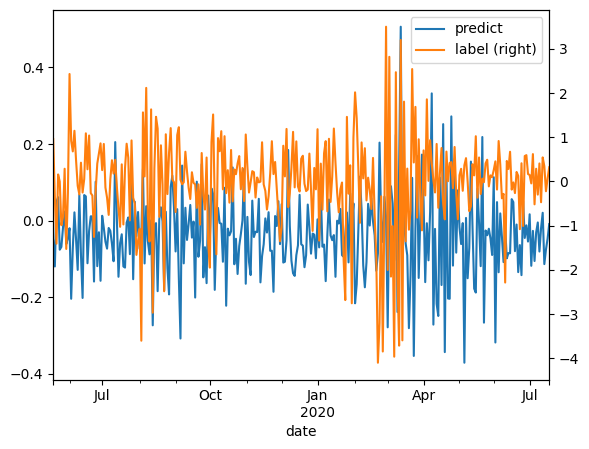

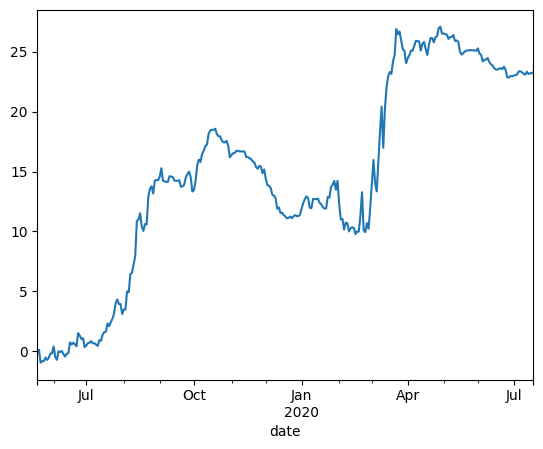

In [ ]:
result_attention_lstm = predict_and_evaluate(model_attention_lstm,test_ds, labels_test[-test_size:])

In [ ]:
result_attention_lstm.to_csv("result_attention_lstm.csv")

In [ ]:
keras.backend.clear_session()
model_attention_lstm = create_model_attention_lstm()
# tf.keras.utils.plot_model(model_mini_transformer,show_shapes=True)

In [ ]:
model_attention_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 768, 60)]        0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 50, 768, 60)          303       ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 tf.math.reduce_mean (TFOpL  (None, 768, 60)              0         ['multi_head_attention[0][0]']
 ambda)                                                                                           
                                                                                              

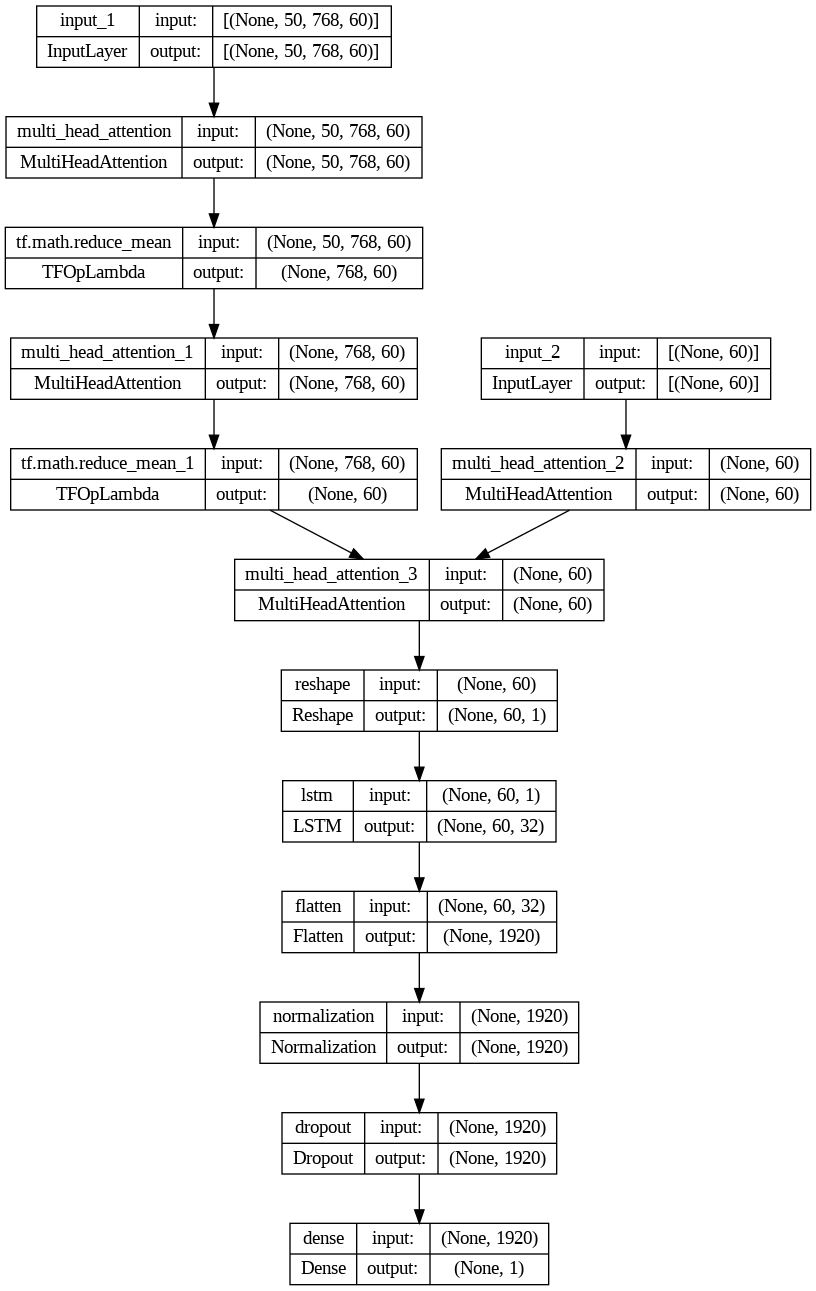

In [ ]:
tf.keras.utils.plot_model(model_attention_lstm, show_shapes=True)

In [ ]:
# model_transformer=create_model_transformer()
hist = model_attention_lstm.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=10,
    callbacks=early_stopping,
    shuffle=True,
)

Epoch 1/10
54/54 [==============================] - 44s 663ms/step - loss: 0.9466 - val_loss: 0.8851
Epoch 2/10
54/54 [==============================] - 35s 650ms/step - loss: 0.9404 - val_loss: 0.9058
Epoch 3/10
54/54 [==============================] - 37s 687ms/step - loss: 0.9174 - val_loss: 0.8798
Epoch 4/10
54/54 [==============================] - 36s 663ms/step - loss: 0.8808 - val_loss: 1.0146
Epoch 5/10
54/54 [==============================] - 37s 682ms/step - loss: 0.8371 - val_loss: 0.9043
Epoch 6/10
54/54 [==============================] - 35s 649ms/step - loss: 0.7976 - val_loss: 0.8798


10/10 [==============================] - 5s 447ms/step
                 label   predict  pos_quantile  pos_sign
label         1.000000  0.095450      0.067065 -0.021032
predict       0.095450  1.000000      0.841842  0.756572
pos_quantile  0.067065  0.841842      1.000000  0.651388
pos_sign     -0.021032  0.756572      0.651388  1.000000


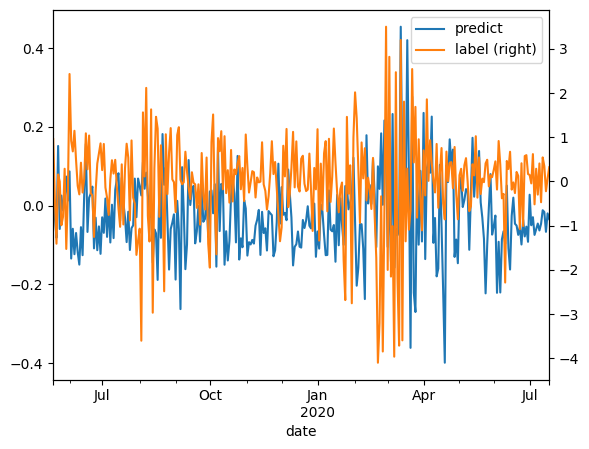

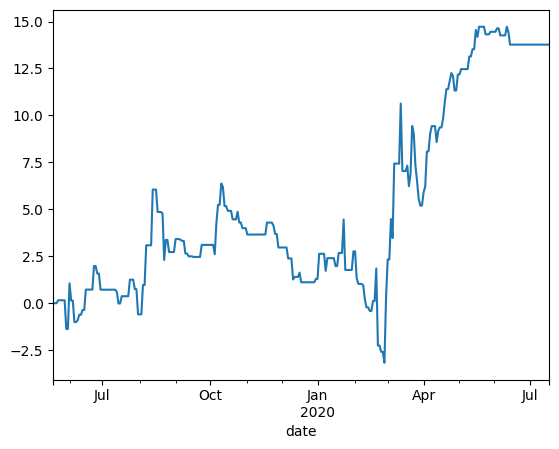

In [ ]:
result_attention_lstm = predict_and_evaluate(
    model_attention_lstm, test_ds, labels_test[-test_size:]
)

In [ ]:
result_attention_lstm.to_csv("result_attention_lstm.csv")

In [ ]:
def create_model_transformer_only_news(
    max_input_len=MAX_X_LEN, dropout=0.3, hidden_dim=32, learning_rate=0.005
):
    # two inputs source
    input_news = tf.keras.layers.Input(shape=(max_input_len, 768, WINDOW))
    input_hist = tf.keras.layers.Input(shape=(WINDOW,))

    # news input with attention
    attention_news = tf.keras.layers.MultiHeadAttention(
        num_heads=2, key_dim=4, attention_axes=1
    )(input_news, input_news)
    attention_news_mean = tf.reduce_mean(
        attention_news, axis=1
    )  # combine data within the same date
    attention_news_token = tf.keras.layers.MultiHeadAttention(
        num_heads=2, key_dim=2, attention_axes=1
    )(attention_news_mean, attention_news_mean)
    attention_news_token_mean = tf.reduce_mean(attention_news_token, axis=1)
    # flatten_news=tf.keras.layers.Flatten()(attention_news_token_mean)
    flatten_news = tf.keras.layers.Normalization()(attention_news_token_mean)
    attention_combine = tf.keras.layers.MultiHeadAttention(
        num_heads=2, key_dim=2, attention_axes=0
    )(flatten_news, flatten_news)

    dropout_news = tf.keras.layers.Dropout(dropout)(flatten_news)
    hidden = tf.keras.layers.Dense(hidden_dim)(dropout_news)
    hidden = tf.keras.layers.Dense(hidden_dim)(hidden)
    reg = tf.keras.layers.Dense(1)(hidden)
    model = tf.keras.models.Model(inputs=(input_news, input_hist), outputs=[reg])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse"
    )
    return model

In [ ]:
def create_model_transformer_ts(
    max_input_len=MAX_X_LEN, dropout=0.3, hidden_dim=32, learning_rate=0.005
):
    # two inputs source
    input_news = tf.keras.layers.Input(shape=(max_input_len, 768, WINDOW))
    input_hist = tf.keras.layers.Input(shape=(WINDOW,))

    # news input with attention
    attention_news = tf.keras.layers.MultiHeadAttention(
        num_heads=2, key_dim=4, attention_axes=1
    )(input_news, input_news)
    attention_news_mean = tf.reduce_mean(
        attention_news, axis=1
    )  # combine data within the same date
    attention_news_token = tf.keras.layers.MultiHeadAttention(
        num_heads=4, key_dim=2, attention_axes=(1, 2)
    )(attention_news_mean, attention_news_mean)
    attention_news_token_mean = tf.reduce_mean(attention_news_token, axis=2)
    # flatten_news=tf.keras.layers.Flatten()(attention_news_token_mean)
    flatten_news = tf.keras.layers.Normalization()(attention_news_token_mean)
    # dropout_news=tf.keras.layers.Dropout(0.5)(flatten_news)

    # hist returns with attention
    attention_hist = tf.keras.layers.MultiHeadAttention(
        num_heads=2, key_dim=2, attention_axes=1
    )(input_hist, input_hist)
    # flatten_hist=tf.keras.layers.Flatten()(attention_hist)
    flatten_hist = tf.keras.layers.Normalization()(attention_hist)
    # dropout_hist=tf.keras.layers.Dropout(dropout)(flatten_hist)

    # combine two inputs together
    combined = tf.concat([flatten_news, flatten_hist], axis=1)
    # attention_combine=tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=2,attention_axes=0)(combined,combined)
    # flatten_combine=tf.keras.layers.Flatten()(attention_combine)
    hidden = tf.keras.layers.Dense(32)(combined)
    hidden = tf.keras.layers.Dense(32)(hidden)
    # normalized=tf.keras.layers.Normalization()(hidden)
    droput = tf.keras.layers.Dropout(dropout)(hidden)
    reg = tf.keras.layers.Dense(1)(droput)
    model = tf.keras.models.Model(inputs=(input_news, input_hist), outputs=[reg])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse"
    )
    return model

In [ ]:
model_transformer_ts = create_model_transformer_ts()

In [ ]:
hist = model_transformer_ts.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=10,
    callbacks=early_stopping,
    shuffle=True,
)

Epoch 1/10
54/54 [==============================] - 36s 515ms/step - loss: 0.9753 - val_loss: 0.9009
Epoch 2/10
54/54 [==============================] - 28s 503ms/step - loss: 0.9660 - val_loss: 0.9077
Epoch 3/10
54/54 [==============================] - 28s 506ms/step - loss: 0.9402 - val_loss: 0.9940
Epoch 4/10
54/54 [==============================] - 28s 510ms/step - loss: 0.9293 - val_loss: 0.9059


10/10 [==============================] - 4s 410ms/step
                 label   predict  pos_quantile  pos_sign
label         1.000000 -0.006916      0.004072  0.017056
predict      -0.006916  1.000000      0.865501  0.722091
pos_quantile  0.004072  0.865501      1.000000  0.649289
pos_sign      0.017056  0.722091      0.649289  1.000000


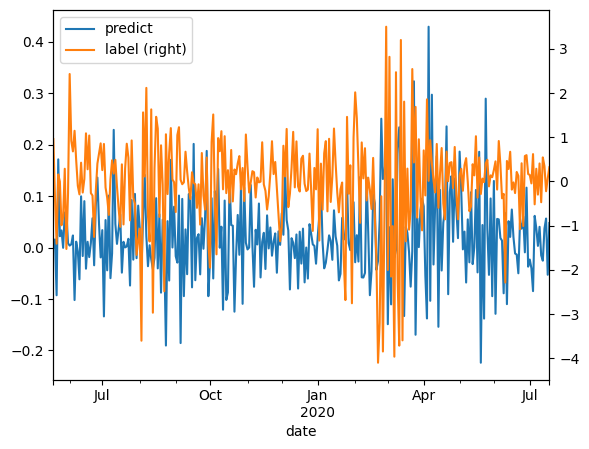

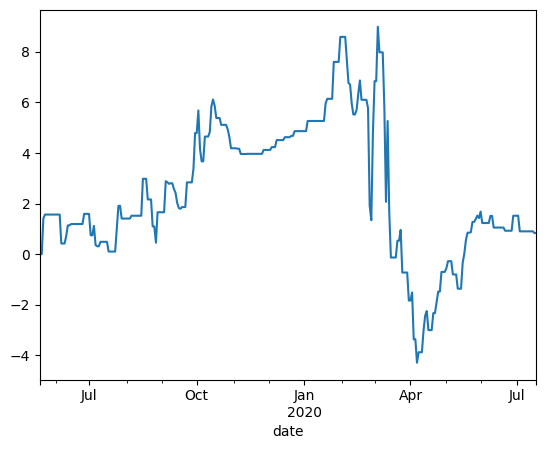

In [ ]:
result_transformer_ts = predict_and_evaluate(
    model_transformer_ts, test_ds, labels_test[-test_size:]
)

In [ ]:
result_transformer.to_csv("result_transformer.csv")

In [ ]:
model_transformer_ts.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 768, 60)]        0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 50, 768, 60)          2004      ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 tf.math.reduce_mean (TFOpL  (None, 768, 60)              0         ['multi_head_attention[0][0]']
 ambda)                                                                                           
                                                                                              

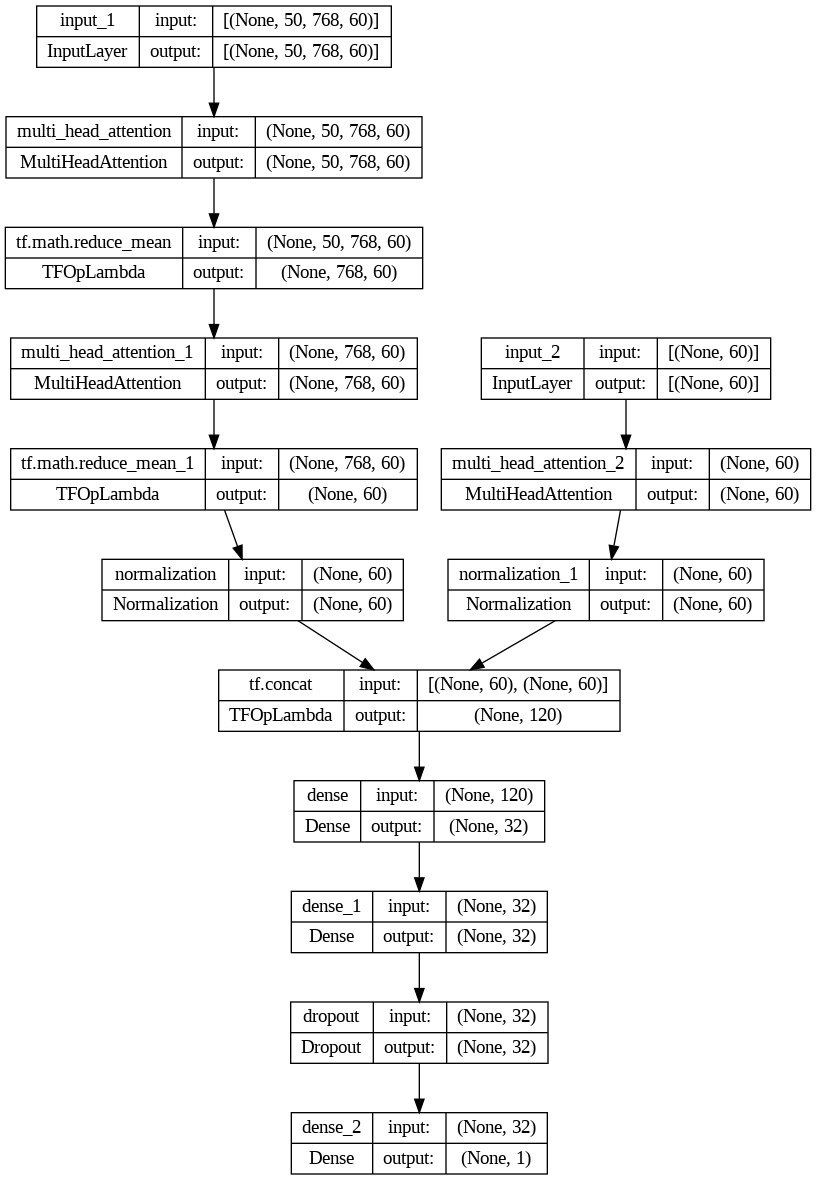

In [ ]:
tf.keras.utils.plot_model(model_transformer_ts, show_shapes=True)

In [ ]:
keras.backend.clear_session()

In [ ]:
model_transformer_only_news = create_model_transformer_only_news()
history = model_transformer_only_news.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=10,
    callbacks=early_stopping,
    shuffle=True,
)

Epoch 1/10
54/54 [==============================] - 36s 593ms/step - loss: 6.3415e-04 - val_loss: 1.0607e-04
Epoch 2/10
54/54 [==============================] - 32s 593ms/step - loss: 2.3187e-04 - val_loss: 1.0159e-04
Epoch 3/10
54/54 [==============================] - 32s 592ms/step - loss: 2.2798e-04 - val_loss: 1.6325e-04
Epoch 4/10
54/54 [==============================] - 32s 591ms/step - loss: 2.3834e-04 - val_loss: 1.1399e-04
Epoch 5/10
54/54 [==============================] - 32s 592ms/step - loss: 2.2788e-04 - val_loss: 9.3912e-05
Epoch 6/10
54/54 [==============================] - 32s 591ms/step - loss: 2.2944e-04 - val_loss: 9.8818e-05
Epoch 7/10
54/54 [==============================] - 31s 579ms/step - loss: 2.3030e-04 - val_loss: 1.3490e-04
Epoch 8/10
54/54 [==============================] - 32s 587ms/step - loss: 2.2980e-04 - val_loss: 1.0540e-04


10/10 [==============================] - 6s 531ms/step
                 label   predict  pos_quantile  pos_sign
label         1.000000  0.021386      0.039771 -0.000910
predict       0.021386  1.000000      0.884044  0.482491
pos_quantile  0.039771  0.884044      1.000000  0.319983
pos_sign     -0.000910  0.482491      0.319983  1.000000


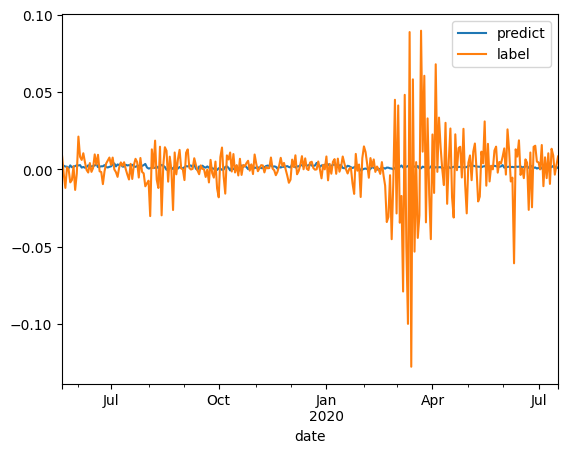

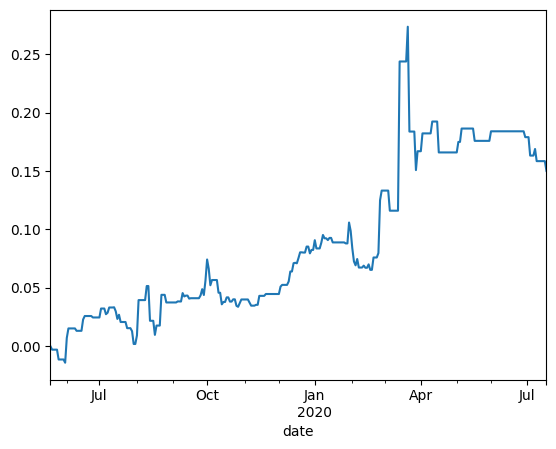

In [ ]:
result_transformer = predict_and_evaluate(
    model_transformer_only_news, test_ds, labels_test[-test_size:]
)

In [ ]:
result_transformer.to_csv("result_transformer_news_only.csv")

In [ ]:
result_transformer

,label,predict,pos_quantile,pos_sign
date,,,,
2019-05-20,0.008460,0.001925,0,1.0
2019-05-21,-0.002828,0.002376,1,1.0
2019-05-22,-0.011986,0.001826,0,1.0
2019-05-23,0.001353,0.001749,0,1.0
2019-05-24,0.000000,0.000707,-1,1.0
...,...,...,...,...
2020-07-13,0.013317,0.001397,0,1.0
2020-07-14,0.009041,0.002229,0,1.0
2020-07-15,-0.003412,0.000963,0,1.0


# Output Table

In [88]:
pio.templates.default = "plotly_white"
pd.options.plotting.backend = "matplotlib"
# pd.options.plotting.backend = "plotly"
plt.style.use('ggplot')

In [89]:
base = pd.read_csv("result_finbert_nltk.csv", index_col=0, parse_dates=True)
base.index = pd.to_datetime(base.index)

In [92]:
base['label_z']=labels_test.reindex(base.index)

In [93]:
base['label_z'].hasnans

False

In [94]:
predicts = []
for r in [
    "result_avg_single_day",
    "result_attention_single_day",
    "result_attention_lstm",
    "result_transformer_autohp",
]:
    results_df = pd.read_csv(r + ".csv", index_col=0, parse_dates=True)
    results_df.index = pd.to_datetime(results_df.index)
    predicts.append(results_df["predict"].rename(r))

In [95]:
predicts = pd.concat(
    [base[["label", "nltk_prob_diff", "prob_diff"]]] + predicts, axis=1
).dropna()

In [96]:
predicts.columns = [
    "Target",
    "Lexicon senti",
    "FinBERT Senti",
    "FB Avg",
    "FB Attention",
    "FB LSTM",
    "FB Transformer",
]

In [97]:
pearson_correl = predicts.corr().loc["Target"]
spearman_correl= predicts.corr(method='spearman').loc["Target"]

In [98]:
mae = predicts.sub(base['label_z'], axis=0).abs().mean()
mse = (predicts.sub(base['label_z'], axis=0) ** 2).mean()

In [99]:
stats_eval = pd.concat([pearson_correl, spearman_correl,mae,mse], axis=1)
stats_eval.columns = ["pearson_correl", "spearman_correl","mae","mse"]

In [100]:
stats_eval.round(4)

,pearson_correl,spearman_correl,mae,mse
Target,1.0000,1.0000,0.7269,1.0991
Lexicon senti,0.0224,-0.0026,0.7376,1.1331
FinBERT Senti,-0.0129,-0.0291,0.7747,1.1749
FB Avg,0.0122,0.0129,0.7468,1.1361
FB Attention,0.0413,0.0435,0.7367,1.1318
FB LSTM,0.1424,0.0649,0.7451,1.1178
FB Transformer,0.1301,0.1260,0.7384,1.1331


In [ ]:
signals=np.tanh(zscore_roll(predicts,200,200))

<Axes: xlabel='date'>

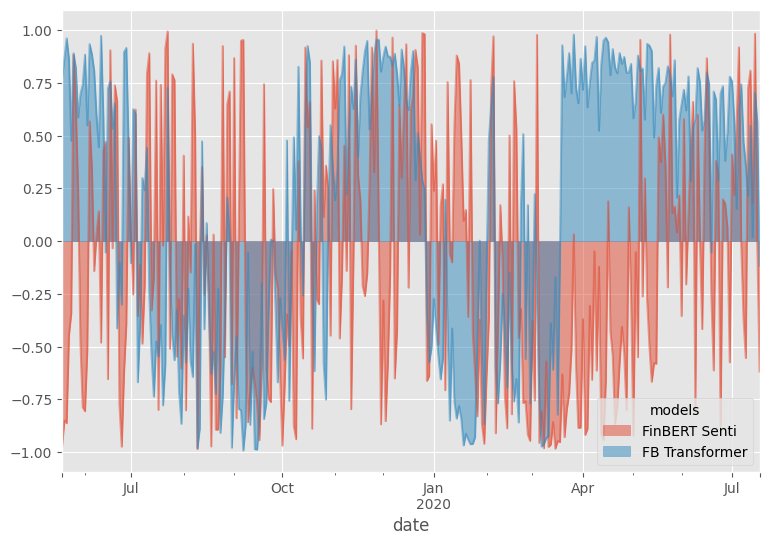

In [ ]:
signals[['FinBERT Senti','FB Transformer']].plot.area(stacked=False,figsize=(9,6))

In [ ]:
strat_returns = signals.mul(predicts["Target"], axis=0)
strat_returns["Target"] = predicts.dropna()["Target"]

In [ ]:
total_return = strat_returns.sum()
sharpe_ratio = (strat_returns.mean() / strat_returns.std()) * 252**0.5
max_drawdown = strat_returns.cumsum().sub(strat_returns.cumsum().cummax()).min()
strategy_eval = pd.concat([total_return, sharpe_ratio, max_drawdown], axis=1)
strategy_eval.columns = ["total_return", "sharpe_ratio", "max_drawdown"]

In [ ]:
pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"
strat_returns.columns.name='models'
(1+strat_returns.cumsum()).rename(columns={'Target':"S&P 500"}).plot( width=600,height=400)

In [ ]:
final_output = pd.concat([stats_eval, strategy_eval], axis=1)

In [ ]:
final_output.round(4)

,pearson_correl,spearman_correl,mae,mse,total_return,sharpe_ratio,max_drawdown
Target,1.0000,1.0000,0.0000,0.0000,0.1353,0.3595,-0.4144
Lexicon senti,0.0224,-0.0026,0.0240,0.0010,0.0898,0.3260,-0.2018
FinBERT Senti,-0.0129,-0.0291,0.1909,0.0481,0.0263,0.0887,-0.2294
FB Avg,0.0122,0.0129,0.0867,0.0089,0.0263,0.1037,-0.2711
FB Attention,0.0413,0.0435,0.0150,0.0005,0.1415,1.2109,-0.0927
FB LSTM,0.1424,0.0649,0.0882,0.0135,0.4144,1.5723,-0.1232
FB Transformer,0.1301,0.1260,0.0170,0.0005,0.5827,2.1517,-0.0617


In [ ]:
final_output.to_csv("final_output.csv")